各列のデータの関係を調べる
=======================

一つ一つの列について，どのようなデータが入っているかは調べました．

これから列同士の関係を調べていきましょう．前回同様，データを入手するところから始めていきます．

In [1]:
import numpy as np
import pandas as pd
import pathlib

train_data_path = pathlib.Path("../input/spaceship-titanic/train.csv")
train_data = pd.read_csv(
    train_data_path,
    dtype={
        "PassengerId": "string",
        "HomePlanet": "string",
        "Cabin": "string",
        "Destination": "string",
    },
)

## 散布図を出す

数値属性の列の組については，相関係数を求めることで関係を調べることができますが，相関係数だけだと数値が出てくるだけで分布の仕方がわからないので，散布図を出しましょう

ヒストグラムを出したときに，`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` の分布は似通っていましたね．

互いに関係があるのか，散布図を出力して調べてみましょう．

`scatter_matrix` という関数を使うと，指定した列の任意の組に対する散布図を出力してくれます．

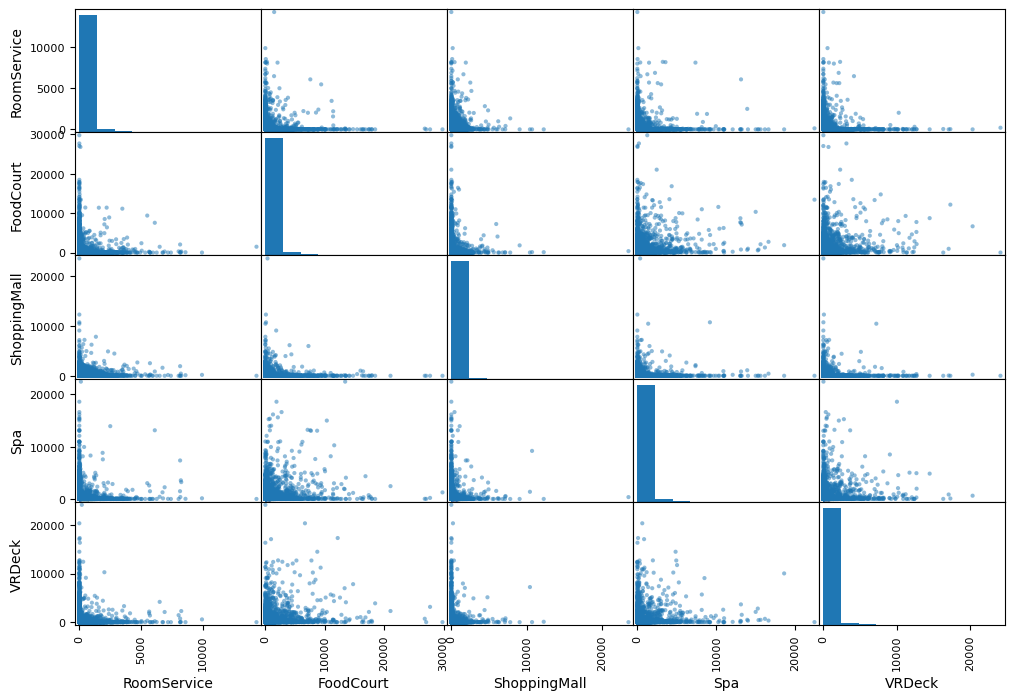

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

attributes = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
scatter_matrix(train_data[attributes], figsize=(12, 8), diagonal='hist')
plt.show()

```{note}
対角線上は同じ列同士の相関を調べても仕方ないので，ヒストグラムを出しています．
```

散布図を見る限り，どの２組に対しても相関関係はないようですね．

ただ，一方が大きければもう一方は小さくなる傾向はありそうです．

## ヒストグラムを重ねる

予測対象の列 `Transported` は数値ではありませんが，相関係数を計算することは可能です．

`corr` で列同士の相関係数を計算して，`Transported` との相関係数の値が高い順に出力してみましょう．

In [3]:
corr_matrix = train_data.corr(numeric_only=True)
corr_matrix["Transported"].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.046566
ShoppingMall    0.010141
Age            -0.075026
VRDeck         -0.207075
Spa            -0.221131
RoomService    -0.244611
Name: Transported, dtype: float64

`VRDeck` と `Spa` と `RoomService` の３つが比較的強い負の相関を持っていることがわかります．

逆に `FoodCourt` と `ShoppingMall` と `Age` の相関は弱いですね．

しかし，相関係数を出すだけだとやはり分布がわからないので，ここでもヒストグラムを出してみましょう．

### 相関が強かった方

相関が強かった方から始めます．

`Transported` の値が True であるか False であるかで場合分けしてヒストグラムを出し，それを重ねます．

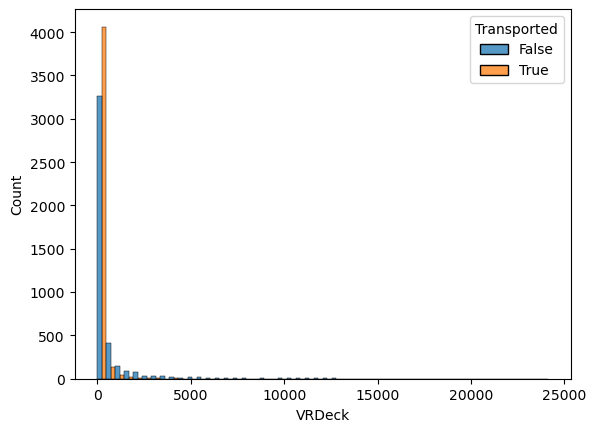

In [4]:
import seaborn as sns

sns.histplot(data=train_data, x="VRDeck", hue="Transported", multiple="dodge", bins=50)
plt.show()

ヒストグラムが出せました．しかし，0 付近以外は値が小さすぎて見づらいですね．

横軸を対数スケールにしてもう一度ヒストグラムを出しましょう．

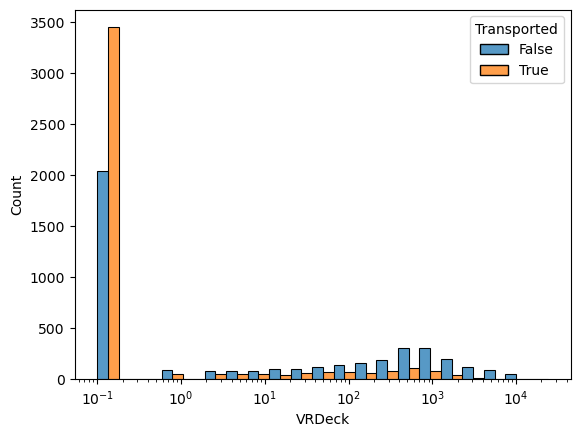

In [5]:
import seaborn as sns

sns.histplot(
    data=train_data.replace(0, 0.1),
    x="VRDeck",
    hue="Transported",
    multiple="dodge",
    log_scale=True,
)
plt.show()

```{note}
対数関数は０での値がマイナス無限大になりますが，無限大になるとヒストグラムが書けないので，０の部分は 0.1 に置き換えてグラフを書いています．
```

見やすいグラフになりました．

これを見ると，`VRDeck` を使用していない（つまり図で値が 0.1 になっている）ことと，`Transported` が True であることが同時に起こりやすいことがわかりますね．

他の特徴量に関しても，同様にして視覚化していきましょう．

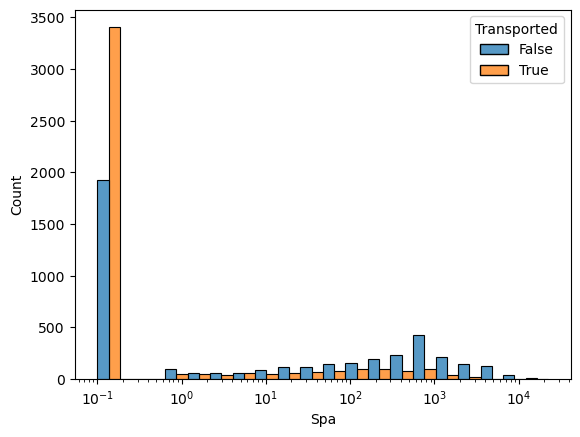

In [10]:
sns.histplot(
    data=train_data.replace(0, 0.1),
    x="Spa",
    hue="Transported",
    multiple="dodge",
    log_scale=True,
)
plt.show()

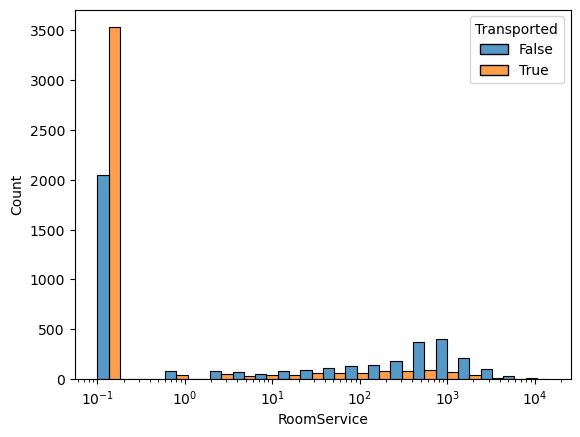

In [11]:
sns.histplot(
    data=train_data.replace(0, 0.1),
    x="RoomService",
    hue="Transported",
    multiple="dodge",
    log_scale=True,
)
plt.show()

### 相関が弱かった方

相関が弱かった `FoodCourt` と `ShoppingMall` と `Age` についても調べましょう．

どんな分布になっているでしょうか？

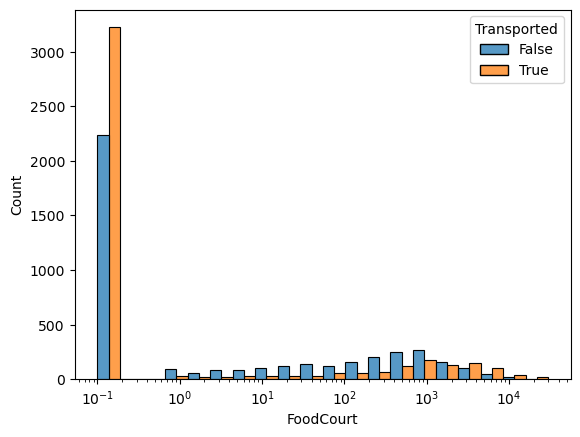

In [6]:
sns.histplot(
    data=train_data.replace(0, 0.1),
    x="FoodCourt",
    hue="Transported",
    multiple="dodge",
    log_scale=True,
)
plt.show()

`FoodCourt` に関しても，相関が強かった列と同様に使用しなかった人の過半数が異次元に飛ばされてしまっています．

しかし，非常に多く利用したひとに関してはむしろ異次元に飛ばされやすいため，相関係数が中途半端になっていたようです．

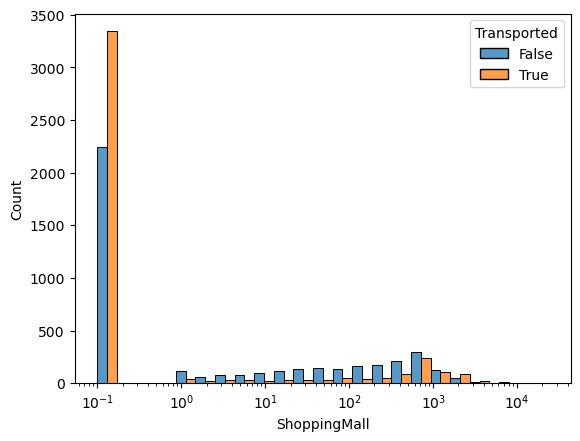

In [8]:
sns.histplot(
    data=train_data.replace(0, 0.1),
    x="ShoppingMall",
    hue="Transported",
    multiple="dodge",
    log_scale=True,
)
plt.show()

`ShoppingMall` にも `FoodCourt` と同じ傾向があります．

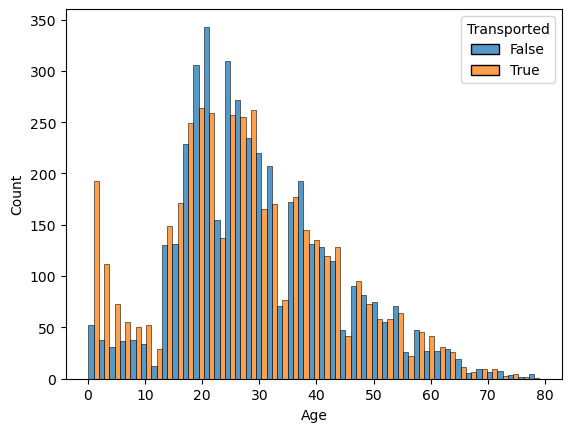

In [13]:
sns.histplot(
    data=train_data.replace(0, 0.1),
    x="Age",
    hue="Transported",
    multiple="dodge"
)
plt.show()

`Age` との関係はちょっと複雑です．

* 年齢が 10 歳以下だと異次元に飛ばされやすい一方で，
* 年齢が 20 代だと飛ばされにくく，

30歳以上の年齢ではほとんど差がありません．

## クロステーブル集計

数値列と Bool 値の列の関係の可視化は，ヒストグラムを重ねる方法でできました．

では Bool 値同士とか，カテゴリ量と Bool 値だった場合はどうしたらいいでしょうか？

一つの方法は，クロステーブルを作ることです．やってみましょう．

In [17]:
pd.crosstab(
    train_data["CryoSleep"], train_data["Transported"]
)

Transported,False,True
CryoSleep,,
False,3650,1789
True,554,2483


簡潔な表になりましたが，視覚的にわかりやすくはないかもしれません．

`CryoSleep` の各値に対して，何%が飛ばされて，何%が飛ばされなかったのかがパッとわかった方がよい良い視覚化です．

ヒートマップを使ってみましょう．

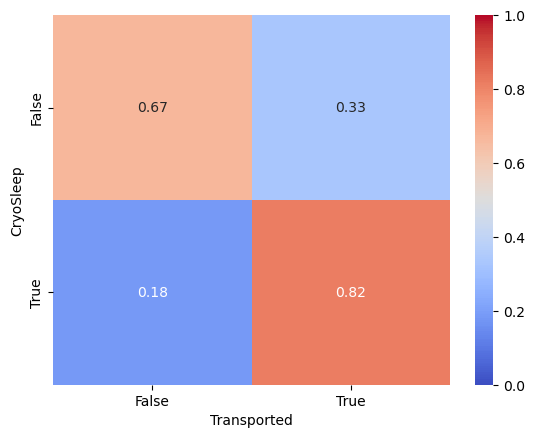

In [32]:
sleep_cross = pd.crosstab(
    train_data["CryoSleep"], train_data["Transported"], normalize="index"
)
cmap = sns.color_palette("coolwarm", 200)
sns.heatmap(sleep_cross, cmap=cmap, vmax=1, vmin=0, annot=True)
plt.show()

```{note}
`crosstab` のオプションで `normarize` を指定することにより，足して１になるように正規化することができます．

これは，割合や確率を求めることに対応しています．
```

```{note}
`Transported` の円グラフを出力したときに判明したように，何も情報がなければ飛ばされる確率は 50% です．
そこで，0.5 を境に寒色と暖色が入れ替わるようなカラーマップを使用しています．
```

`CryoSleep` が True だと，82% の確率で飛ばされてしまうことがわかりましたね．関係がありそうです．

他の特徴量に対しても，同様に可視化を試みましょう．

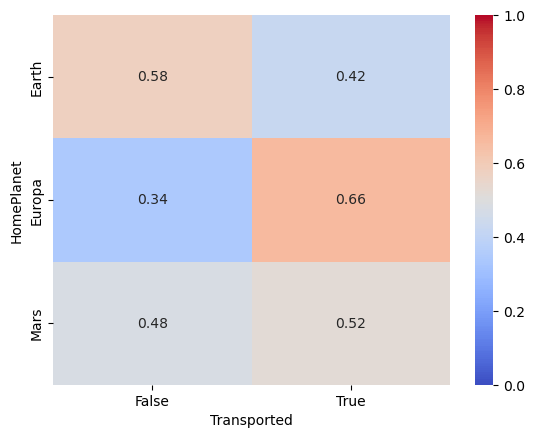

In [33]:
planet_cross = pd.crosstab(
    train_data["HomePlanet"], train_data["Transported"], normalize="index"
)
cmap = sns.color_palette("coolwarm", 200)
sns.heatmap(planet_cross, cmap=cmap, vmax=1, vmin=0, annot=True)
plt.show()

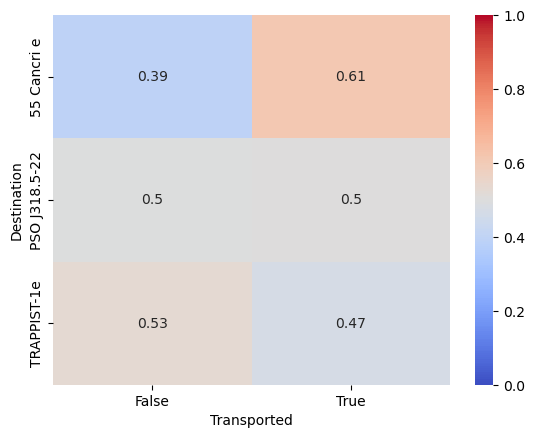

In [34]:
destination_cross = pd.crosstab(
    train_data["Destination"], train_data["Transported"], normalize="index"
)
cmap = sns.color_palette("coolwarm", 200)
sns.heatmap(destination_cross, cmap=cmap, vmax=1, vmin=0, annot=True)
plt.show()

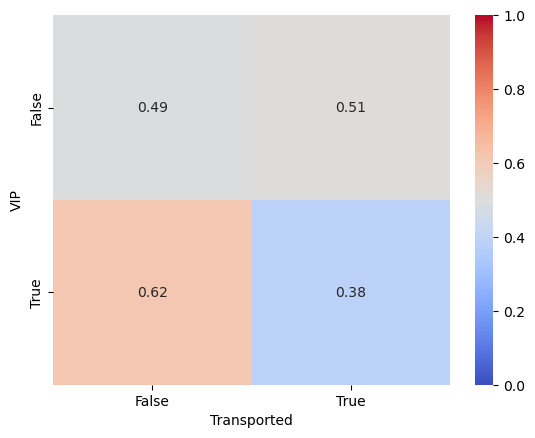

In [35]:
vip_cross = pd.crosstab(
    train_data["VIP"], train_data["Transported"], normalize="index"
)
cmap = sns.color_palette("coolwarm", 200)
sns.heatmap(vip_cross, cmap=cmap, vmax=1, vmin=0, annot=True)
plt.show()